# Title

## Introduction

Minecraft is a sandbox video game where players explore and build in a world made of blocks. In this world of infinite possibilities, we would like to analyze the relationship between player behaviors and their demographics. This data was collected by a Computer Science research group at UBC led by Frank Wood. The method in which they collected data was recording players' actions throughout the world in their Minecraft servers. They provide two data sets, one of player data that contains a list of unique players and their data, and another that contains a list of individual game sessions made by each player. Specifically, we would like to know what Minecraft player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how each player differs from each other.
### Question:
Can the variables played_hours, gender, experience, and age predict whether or not a Minecraft player will subscribe to a game-related newsletter, and how do these predictors vary from player to player?

As we are only looking at player demographic and behavioural data, we will only use the first data set, players.csv that contains the list of players and their respective game data. This data set contains 196 total observations and 7 variables: subscribe, gender, age, name, played_hours, hashedEmail and experience. Out of all the variables, the predictors of subscribing are experience, played_hours, gender and age. The columns email and name will be left out as these varibles do not contribute to newsletter subscription.

- The subscribe variable is categorical and contains 2 possible values: "TRUE" or "FALSE". This shows whether a player has subscribed to a game related newsletter or not.

- The experience variable is categorical and contains 5 possible values: "Beginner", "Amateur", "Regular", "Pro" and "Veteran". These placeholders describe the level of skill and experience each player has rated themselves from least to most experienced.

- The played_hours variable is numeric and up to 1 decimal place. This variable, quantified in hours, was determined through how long each player played Minecraft in one sitting.

- The gender variable is categorical and contains 7 options: "Male", "Female", "Non-binary", "Prefer not to say", "Agender", "Two-spirited" and "Other." This variable shows the gender of the player.

- The age variable is numeric and contains integer values. This variable is the age of the player.

A noticeable issue is that this data contains some outliers in the played_hours variable. Some players have claimed to play over 200 hours of Minecraft in a single session. These points may affect the classification model in predictions. 



### players.csv dataset  Information
#### Dataframe
- 196 Observations
- 7 Variables
- Experience was collected from players themselves
- Each name is unique currently but that is not guaranteed
- Issue: Age has 2 N/A values
- Note: Age starts with a capital A
#### Variables
| Name | Type | Description |
| :------- | :------ | :-------
| experience | chr | Categorical (Pro, Veteran, Amateur, Regular, Beginner)  | 
| subscribe | lgl | Categorical (TRUE/FALSE) |
| hashedEmail | chr | Identifies players |
| played_hours | dbl | Numerical (Total amount of hours played) |
| name | chr | Identifies players |
| gender | chr | Categorical (Male, Female, Non-binary, Prefer not to say, Agender, Two-Spirited, Other) |
| Age | dbl | Numerical (Age of the player) |
#### Summary Statisitics
| Name | Unique Observations | Max | Min | Mean |
| :------- | :------ | :-------| :-------| :-------
| played_hours | 43 | 223.1 | 0 | 5.85 |
| Age | 33 | 58 | 9 | 21.14 |
| experience | 5 | - |  - | - | 
| subscribe | 2 | - | - | - | 
| hashedEmail | 196 | - | - | - |  
| name | 196 | - | - | - | 
| gender | 7 | - | - | - |  

## Methods & Results

We began by wrangling and cleaning the dataset. Specifically, we converted any “Prefer not to say” entries in the gender column into NA values and changed the column name “Age” to “age” so that all variable names follow a lowercase format. This ensures that functions using arguments like na.rm = TRUE will work properly during our analysis.

In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6) # i got these loading steps from other assignments we've done. im not really sure
#source('cleanup.R') # if they are all necesary tho so feel free to remove

# loading in dataset
players = read_csv("data/players.csv")
players

# changing age column name + converting "Prefer not to say" into NAs
clean_data <- players |>
  mutate(age = Age,
    gender = na_if(gender, "Prefer not to say")   # convert to NA
  ) |>
  select(-Age)
clean_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


experience,subscribe,hashedEmail,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,NA,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


age,played_hours,subscribe
<dbl>,<dbl>,<lgl>
9,30.3,TRUE
17,3.8,TRUE
17,0.0,FALSE
⋮,⋮,⋮
57,0.0,FALSE
17,2.3,FALSE
NA,0.2,TRUE


(If we want to make it a bit more complicated) First we need to load in both dataset and wrangle them seperately. For the session.csv data we will tidy the data and then group by each individual email and find the number of sessions they have played. For players.csv we will change the varibale name 'Age' to 'age' to follow a consistent naming pattern, and then select the variables we will use as predictors. From here we can merge the two datasets. 

In [24]:
sessions = read_csv("data/sessions.csv")

tidy_session_data <- sessions |>
        separate(col = start_time,
                into = c('start_date', 'start_time'),
                sep = ' ') |>
        separate(col = end_time,
                into = c('end_date', 'end_time'),
                sep = ' ')

# combining the observations so that each hashedEmail has the number of sessions played beside it
indiv_sessions <- tidy_session_data |> 
group_by(hashedEmail) |>
summarize(sessions_played = n()) 

#data wrangeling for players
predictor_data <- players |>
    mutate(age = Age,
          subscribe = as.factor(subscribe)) |>
    select(age, played_hours, subscribe, hashedEmail) |>
    drop_na()

complete_data <- merge(x = predictor_data, y = indiv_sessions, by = "hashedEmail")
minecraft_data <- select(complete_data, -hashedEmail)


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [28]:
set.seed(1243)

minecraft_split <- initial_split(minecraft_data, prop = 0.75, strata = subscribe)  
minecraft_train <- training(minecraft_split)   
minecraft_test <- testing(minecraft_split)

minecraft_recipe <- recipe(subscribe ~., data = minecraft_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

knn_tune <- nearest_neighbor(weight_func = 'rectangular' , neighbors = tune()) |>
      set_engine('kknn') |>
      set_mode('classification')

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

minecraft_vfold <- vfold_cv(minecraft_train, v = 5, strata = subscribe)

knn_results <- workflow() |>
      add_recipe(minecraft_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = minecraft_vfold, grid = k_vals) |>
      collect_metrics()
knn_results


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6058136,5,0.03590804,Preprocessor1_Model01
1,roc_auc,binary,0.5607692,5,0.05013555,Preprocessor1_Model01
2,accuracy,binary,0.6058136,5,0.03590804,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19,roc_auc,binary,0.6284615,5,0.021749776,Preprocessor1_Model19
20,accuracy,binary,0.7394909,5,0.006910322,Preprocessor1_Model20
20,roc_auc,binary,0.5672527,5,0.037497977,Preprocessor1_Model20


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.7611971,5,0.02739855,Preprocessor1_Model11


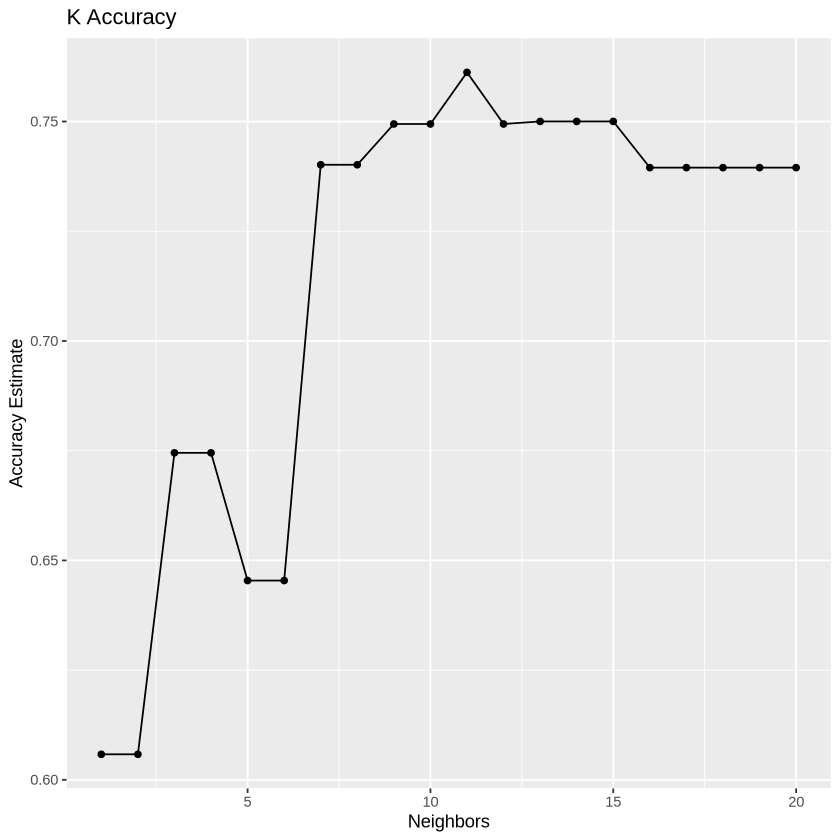

In [33]:
accuracies <- knn_results |> 
      filter(.metric == 'accuracy') 

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle('K Accuracy')
accuracy_versus_k 

best_k <- slice_max(accuracies, order_by= mean, n=1)
best_k